#  Maximum Likelihood Estimation with Bivariate Gaussians
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Zeyuzhao/Notebooks/blob/master/mle_gaussian.ipynb)


## Data Generation

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.distributions.multivariate_normal as normal
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
# We offset the distribution by the mean
mean = [0.5, 1.5]

# This is cholsky decomposition of the covariance matrix
# Ensures that the covariance matrix is semi-positive definite
L = np.array([[1, -1.5], 
              [0, 1]]) / 2
cov = L @ L.T
cov

array([[ 0.8125, -0.375 ],
       [-0.375 ,  0.25  ]])

In [3]:
# Generates 
rng = np.random.default_rng(seed=41)
(x, y) = rng.multivariate_normal(mean, cov, 500).T

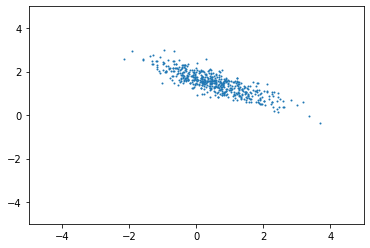

In [4]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

ax.scatter(x, y, s=1)
plt.show()

In [5]:
# Compute mean and covariance

combinedxy = np.stack([x, y], axis = 1)

np.cov(combinedxy.transpose())
np.mean(combinedxy, axis=0)

array([0.52975302, 1.48668041])

## MLE with gradient descent

$$\DeclareMathOperator*{\argmax}{arg\,max}$$
$$\argmax_{\theta} \sum_{x \in D}^{}\frac{1}{|D|}\log(p_{\theta}(x))$$

In [6]:
# Cost Function

X = torch.from_numpy(x).float()
Y = torch.from_numpy(y).float()

mean = torch.zeros((2), requires_grad=True)
cov = torch.eye(2, requires_grad=True)

learning_rate = 8e-3

m = normal.MultivariateNormal(mean, cov)

hist_mean = []
hist_cov = []
hist_loss = []

In [7]:
dataset = torch.stack([X, Y], dim=1)
n = len(dataset)
iterations = 500

for t in range(iterations):
    m = normal.MultivariateNormal(mean, cov)
    J = -1/n * m.log_prob(dataset).sum()

    J.backward()
    with torch.no_grad():
        mean -= learning_rate * mean.grad
        cov -= learning_rate * cov.grad

        mean.grad.zero_()
        cov.grad.zero_()

    if t % 100 == 99:
        print("Iteration: {0}\tLoss: {1}".format(t, J))
        print(mean_val)
    if t % 10 == 9:
        mean_val = mean.cpu().detach().clone().numpy()
        cov_val = cov.cpu().detach().clone().numpy()
        loss_val = J.cpu().detach().clone().numpy()
        hist_mean.append(mean_val)
        hist_cov.append(cov_val)
        hist_loss.append(loss_val)

Iteration: 99	Loss: 2.7041077613830566
[0.26284227 0.71079963]
Iteration: 199	Loss: 2.3734664916992188
[0.42486995 1.1314985 ]
Iteration: 299	Loss: 1.7261747121810913
[0.5246653 1.3861424]
Iteration: 399	Loss: 1.4844149351119995
[0.5483833 1.4772981]
Iteration: 499	Loss: 1.484270691871643
[0.538409  1.4823283]


## Visualization

### Final Gaussian Model Plot

In [8]:
meshX, meshY = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((meshX, meshY))

density = multivariate_normal(hist_mean[-1], hist_cov[-1])
meshZ = density.pdf(pos)

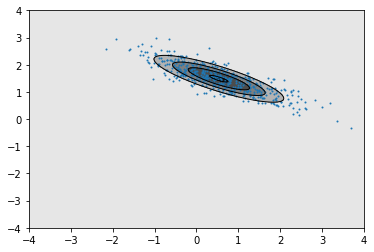

In [9]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)


ax.contour(meshX, meshY, meshZ, levels=4, linewidths=1, colors='k')
ax.contourf(meshX, meshY, meshZ, levels=4, cmap="binary")

ax.scatter(x, y, s=1)
plt.show()

### Model Animation of Training

In [10]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Create mesh for plotting
meshX, meshY = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((meshX, meshY))

# Compute initial densities
density = multivariate_normal(hist_mean[0], hist_cov[0])
meshZ = density.pdf(pos)

# Initialize contour and filled contour plots
contours = [0] * 2
contours[0] = ax.contourf(meshX, meshY, meshZ, levels=4, cmap="binary");
contours[1] = ax.contour(meshX, meshY, meshZ, levels=4, linewidths=1, colors='k');

# Initialize loss label box
props = dict(boxstyle='round', facecolor='whitesmoke')
losslabel = ax.text(0.15, 0.1, "", transform=ax.transAxes, ha="center", bbox=props)

def update(i):
    # Clear contour plot cache
    for tp in contours[0].collections:
        tp.remove()
    for tp in contours[1].collections:
        tp.remove()
    
    # Update contour plots with historic training parameters
    density = multivariate_normal(hist_mean[i], hist_cov[i])
    meshZ = density.pdf(pos)
    contours[0] = ax.contourf(meshX, meshY, meshZ, levels=6, 
                              cmap="binary", vmin=0, vmax=0.65)
    contours[1] = ax.contour(meshX, meshY, meshZ, levels=6, 
                             linewidths=1, colors='k')
    # Display historic training loss
    losslabel.set_text("Loss: {0:.3f}".format(hist_loss[i]))
    # Overlay data scatter plot
    ax.scatter(x, y, s=2, color="c", alpha=0.5)
    return contours[0].collections + contours[1].collections

anim = matplotlib.animation.FuncAnimation(fig, update, frames=len(hist_mean)* 3 // 4, 
                                         interval=50, blit=True, repeat=True)

In [11]:
HTML(anim.to_jshtml())

### KL Divergence and Maximum Likelihood Estimation
We would like to match the parametric distribution $p_{\theta}$ with the empirical distribution $p_{data}$.

To do so, we will minimize the KL divergence of the two distributions with respect to $\theta$:
$\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}$
\begin{equation}
\begin{split}
\theta_{ML} &= \argmin_{\theta} D_{KL}(p_{data}\parallel p_{\theta}) \\
            &= \argmin_{\theta} \E_{x \sim p_{data}}[\log p_{data}(x) - \log p_{\theta}(x)] \\
            &= \argmin_{\theta} -\E_{x \sim p_{data}}[\log p_{\theta}(x)] \\
            &= \argmax_{\theta} \E_{x \sim p_{data}}[\log p_{\theta}(x)]
\end{split}
\end{equation}

The last equation is the maximum likelihood estimator for the parameter $\theta_{ML}$. We can express this empirically by averaging samples from the empirical dataset $D$.
$$
\argmax_{\theta} \sum_{x \in D}^{}\frac{1}{|D|}\log(p_{\theta}(x))
$$

We run a gradient ascent algorithm to find the optimal parameters $\theta_{ML}$.